# Refining Noise (Stable Diffusion v1.5)

This notebook goes through a simple example of aligning noise in stable diffusion 1.5.  The goal is to increase the alignment of the input text prompt and the resultant image.  We can do this simply and efficient using a linear combination of the models outputs.

## Setup

First, install the diffusers library.

In [1]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


Import libraries.

In [2]:
from diffusers import StableDiffusionPipeline
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

Download Stable Diffusion.

In [3]:
# Download stable diffusion from huggingface
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Move model to GPU
device = "cuda:0"
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Define helper functions.

In [4]:
# Set random seed for reproducability
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

## Noise Refining

Our noise aligning algorithm is as follows:

1. $n\sim \mathcal{N}(0,I)$
2. Repeat:
	1. $\nabla \log p(y|n) = \nabla \log p(n|y) - \nabla \log p(n)$ 
	2. $d = \text{NormClipping}(\nabla \log p(y|n))$
	3. $n = n - d + \mathcal{N}(0,0.001 \cdot I)$
	4. $n = \frac{n\sqrt{d}}{|n|}$ 

where $y$ is our condition (e.g. a text prompt).

In [5]:
def align_noise(latents, prompts, device, pipe, aligning_steps=20):
    
    # Get latent dimensions
    b, c, w, h = latents.shape
    
    # Duplicate latents for CFG
    t = torch.tensor(999, device=device)
    prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(prompts,device,1,True)
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    #  Calculate total dimension of the image
    dimensions = len(torch.flatten(latents[0]))

    for _ in range(aligning_steps):
        # Copy noise for conditional/unconditorch.flatten()tion generation
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input.half(),
            t,
            encoder_hidden_states=prompt_embeds.half(),
            return_dict=False,
        )[0]

        # Find the direction
        dir = (noise_pred[b:] - noise_pred[:b]).detach()

        # Gradient norm clipping of direction
        clip_mag = 0.5
        dir_norm = torch.norm(dir.view(-1, c * w * h), dim=1)
        mask = dir_norm > clip_mag
        dir = torch.where(
            mask[:, None, None, None], 
            clip_mag * (dir / dir_norm[:, None, None, None]), 
            dir
        ).view(-1, c, w, h)
        
        # Push the noise in a particular direction
        step_size = 1.0
        latents -= dir * step_size
        
        # Add a small amount of noise at every step (following arxiv:2303.13703)
        noise_level = 0.001
        latents += torch.tensor(np.random.randn(b, c, w, h), device=device).half() * np.sqrt(noise_level)
        
        # Normalize latent to be the expected magnitude
        latent_norms = torch.norm(latents.view(-1, c * w * h), dim=1)[:,None,None,None]
        latents = (latents / latent_norms) * np.sqrt(dimensions)

    return latents

## No Guidance Setting

Refining noise can lead to significant improvements in the case where no guidance is used during generation.  To demonstrate this, first lets generate an image using regular gaussian noise sampled from the standard normal.

In [6]:
# Generate an image using Gaussian noise
set_seed(0)
prompt = "A portrait photo of a happy face"
latents = torch.randn((1, pipe.unet.in_channels, 512 // pipe.vae_scale_factor, 512 // pipe.vae_scale_factor), device=device).half()
with torch.no_grad():
    img_before = pipe(prompt, num_inference_steps=20, latents=latents, guidance_scale=1.0).images[0]

/tmp/ipykernel_51793/4057709903.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 512 // pipe.vae_scale_factor, 512 // pipe.vae_scale_factor), device=device).half()


  0%|          | 0/20 [00:00<?, ?it/s]

Next, lets align this noise for 20 steps, then use that noise to generate another image.

In [7]:
# Align noise, then sample an image with that aligned noise
with torch.no_grad():
    aligning_steps = 20
    aligned_latents = align_noise(latents, prompt, device, pipe, aligning_steps)
    img_after = pipe(prompt, num_inference_steps=20, latents=aligned_latents, guidance_scale=1.0).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

Now, lets display the images we generated.

Text(0.5, 0.98, 'PROMPT: "A portrait photo of a happy face"')

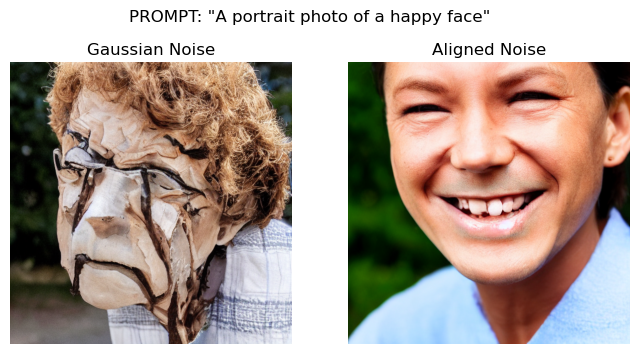

In [8]:
# Display generated images 
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(img_before)
axs[0].set_title("Gaussian Noise")
axs[0].axis('off')
axs[1].imshow(img_after)
axs[1].set_title("Aligned Noise")
axs[1].axis('off')
fig.suptitle("PROMPT: " + "\"" + prompt + "\"")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

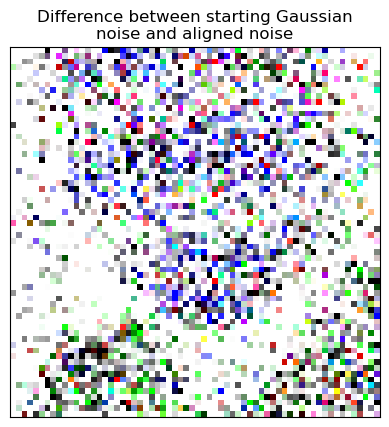

In [9]:
diff = np.transpose((latents - aligned_latents)[0].cpu().float().numpy(), (1,2,0))
plt.imshow(diff*5)
plt.title("Difference between starting Gaussian\nnoise and aligned noise")
plt.xticks([])
plt.yticks([])

## Adding Structure to Noise

Our method can also be used to add structure to our initial noise.  To do this we simple use a structuring prompt when aligning the noise (e.g. "a grid of images").  Then during generation we can use a different prompt to fill in the semantics of the image.

In [10]:
with torch.no_grad():
    img_before = pipe(prompt, num_inference_steps=20, latents=latents).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
# Align noise, then sample an image with that aligned noise
with torch.no_grad():
    aligning_steps = 1
    align_prompt = 'B&W photo, black and white'
    aligned_latents = align_noise(latents, align_prompt, device, pipe, aligning_steps)
    img_after = pipe(prompt, num_inference_steps=20, latents=aligned_latents).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0.98, 'REFINING PROMPT: "B&W photo, black and white"\nGENERATION PROMPT: "A portrait photo of a happy face"')

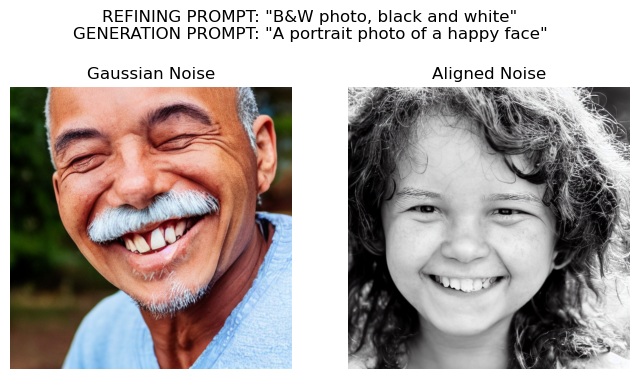

In [17]:
# Display generated images 
fig, axs = plt.subplots(1, 2, figsize=(8,4.5))
axs[0].imshow(img_before)
axs[0].set_title("Gaussian Noise")
axs[0].axis('off')
axs[1].imshow(img_after)
axs[1].set_title("Aligned Noise")
axs[1].axis('off')
fig.suptitle("REFINING PROMPT: " + "\"" + align_prompt + "\"\n" + "GENERATION PROMPT: " + "\"" + prompt + "\"")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

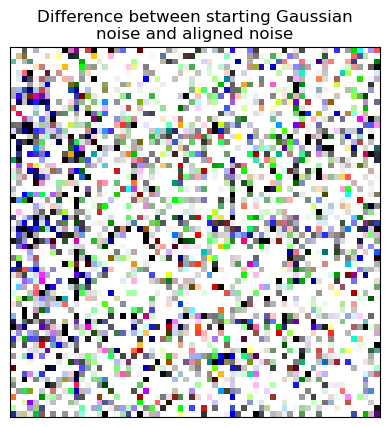

In [ ]:
diff = np.transpose((latents - aligned_latents)[0].cpu().float().numpy(), (1,2,0))
plt.imshow(diff*5)
plt.title("Difference between starting Gaussian\nnoise and aligned noise")
plt.xticks([])
plt.yticks([])